In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import tree
from subprocess import call
import matplotlib.pyplot as plt
import itertools

league = 'english'

start_year = 2005
df = None
files = os.listdir(f'fulldata/{league}')
files.sort()
for file in files:
    year = int(file.strip('.csv'))
    if year < start_year:
        continue
    df_year = pd.read_csv(f'fulldata/{league}/' + file
                          # skiprows=1,
                          # index_col=None,
                          # names=['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A']
                          )
    df_year.reset_index(drop=True, inplace=True)
    df_year['Year'] = year
    df_year['Match'] = df_year.index + 1

    if df is None:
        df = df_year
    else:
        df = df.append(df_year, ignore_index=True, sort=False)

# print(len(df))
# print(df.shape)

# remove unused columns
df_league = None
df.reset_index(inplace=True)
# df = df[['Year', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR',
#          "B365H", "B365D", "B365A"]]

validate_year = 2017
predict_year = 2015
train_year = 2011
teams = ['Arsenal']
# teams = np.unique(df.loc[df['Year'] == predict_year, 'HomeTeam'].values)
teams.sort()
for team in teams:

    df_team = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
    X = pd.DataFrame(
        data={
            'Year': df_team['Year'],
            'Date': df_team['Date'],
            'Team': team,
            'HomeMatch': df_team['HomeTeam'] == team
        }
    )
    X['Opponent'] = np.where(X['HomeMatch'], df_team['AwayTeam'], df_team['HomeTeam'])
    # X['HalfTimeGoals'] = np.where(X['HomeMatch'], df_team['HTHG'], df_team['HTAG'])
    # X['HalfTimeOpponentGoals'] = np.where(X['HomeMatch'], df_team['HTAG'], df_team['HTHG'])
    # X['HalfTimeLead'] = X['HalfTimeGoals'] > X['HalfTimeOpponentGoals']
    # X['HalfTimeLeadMoreThanTwo'] = (X['HalfTimeGoals'] - X['HalfTimeOpponentGoals']) > 2
    # X['FullTimeGoals'] = np.where(X['HomeMatch'], ath_madrid['FTHG'], ath_madrid['FTAG'])
    # X['FullTimeOpponentGoals'] = np.where(X['HomeMatch'], ath_madrid['FTAG'], ath_madrid['FTHG'])
    X['FTR'] = df_team['FTR']
    X['Won'] = np.where(X['HomeMatch'], df_team['FTR'] == 'H', df_team['FTR'] == 'A')
    X['Draw'] = df_team['FTR'] == 'D'
    X['Lost'] = np.where(X['HomeMatch'], df_team['FTR'] == 'A', df_team['FTR'] == 'H')
    X['Result'] = np.where(X['Won'], 'Win', (np.where(X['Lost'], 'Lose', 'Draw')))
    # X['SumGoals'] = X.groupby('Opponent')['FullTimeGoals'].transform(sum)
    X['B365Max'] = np.maximum(np.maximum(df_team['B365H'], df_team['B365A']), df_team['B365D'])
    X['B365Min'] = np.minimum(np.minimum(df_team['B365H'], df_team['B365A']), df_team['B365D'])
    X['B365Say'] = np.where(X['HomeMatch'],
                    # home match
                    np.where(X['B365Max'] == df_team['B365H'], -1,
                             np.where(X['B365Max'] == df_team['B365A'], 1,
                                      0)),
                    # away match
                    np.where(X['B365Max'] == df_team['B365H'], 1,
                             np.where(X['B365Max'] == df_team['B365A'], -1,
                                      0))
                    )
    X['B365Diff'] = np.where(X['B365Say'] == 1, X['B365Max'] - X['B365Min'], X['B365Min'] - X['B365Max'])

    # find number of times won against this opponent in last 5 meetings
    for key, groupByOpponent in X.groupby('Opponent'):
        # keep index as new a column, will be restored and assigned back to X later
        idx = groupByOpponent.index

        # make match day an index because rolling need an index date
        xx = groupByOpponent.set_index('Date')
        xx['idx'] = idx

        # shift to exclude self
        xx['Last5AgainstThisOpponentWon'] = xx['Won'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last5AgainstThisOpponentDraw'] = xx['Draw'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)

        xx['Last3AgainstThisOpponentWon'] = xx['Won'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last3AgainstThisOpponentDraw'] = xx['Draw'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)

        xx['LastAgainstThisOpponentWon'] = xx['Won'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['LastAgainstThisOpponentDraw'] = xx['Draw'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)

        # restore index
        xx = xx.set_index('idx')

        # assign back to the big dataframe
        X.loc[xx.index, 'Last5AgainstThisOpponentWon'] = xx['Last5AgainstThisOpponentWon']
        X.loc[xx.index, 'Last5AgainstThisOpponentDraw'] = xx['Last5AgainstThisOpponentDraw']
        X.loc[xx.index, 'Last3AgainstThisOpponentWon'] = xx['Last3AgainstThisOpponentWon']
        X.loc[xx.index, 'Last3AgainstThisOpponentDraw'] = xx['Last3AgainstThisOpponentDraw']
        X.loc[xx.index, 'LastAgainstThisOpponentWon'] = xx['LastAgainstThisOpponentWon']
        X.loc[xx.index, 'LastAgainstThisOpponentDraw'] = xx['LastAgainstThisOpponentDraw']

    # find recent forms
    idx = X.index
    xx = X.set_index('Date')
    xx['idx'] = idx
    xx['Last5Won'] = xx['Won'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
    xx['Last5Draw'] = xx['Draw'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
    xx['Last3Won'] = xx['Won'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
    xx['Last3Draw'] = xx['Draw'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
    xx['LastWon'] = xx['Won'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
    xx['LastDraw'] = xx['Draw'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
    xx['LastMatch'] = np.where(xx['LastWon'] == 1, 1, np.where(xx['LastDraw'] == 1, 0, -1))
    
    # restore index
    xx = xx.set_index('idx')

    # assign back to the big dataframe
    X.loc[xx.index, 'Last5Won'] = xx['Last5Won']
    X.loc[xx.index, 'Last5Draw'] = xx['Last5Draw']
    X.loc[xx.index, 'Last3Won'] = xx['Last3Won']
    X.loc[xx.index, 'Last3Draw'] = xx['Last3Draw']
    X.loc[xx.index, 'LastWon'] = xx['LastWon']
    X.loc[xx.index, 'LastDraw'] = xx['LastDraw']
    X.loc[xx.index, 'LastMatch'] = xx['LastMatch']

    # replace nan with 0
    # TODO: better way to handle nan
    X.loc[np.isnan(X['Last5AgainstThisOpponentWon']), 'Last5AgainstThisOpponentWon'] = 0
    X.loc[np.isnan(X['Last5AgainstThisOpponentDraw']), 'Last5AgainstThisOpponentDraw'] = 0
    X.loc[np.isnan(X['Last3AgainstThisOpponentWon']), 'Last3AgainstThisOpponentWon'] = 0
    X.loc[np.isnan(X['Last3AgainstThisOpponentDraw']), 'Last3AgainstThisOpponentDraw'] = 0
    X.loc[np.isnan(X['LastAgainstThisOpponentWon']), 'LastAgainstThisOpponentWon'] = 0
    X.loc[np.isnan(X['LastAgainstThisOpponentDraw']), 'LastAgainstThisOpponentDraw'] = 0
    #     X.loc[np.isnan(X['Last5Won']), 'Last5Won'] = 0
    #     X.loc[np.isnan(X['Last5Draw']), 'Last5Draw'] = 0
    #     X.loc[np.isnan(X['Last3Won']), 'Last3Won'] = 0
    #     X.loc[np.isnan(X['Last3Draw']), 'Last3Draw'] = 0
    #     X.loc[np.isnan(X['LastWon']), 'LastWon'] = 0
    #     X.loc[np.isnan(X['LastDraw']), 'LastDraw'] = 0

    # restrict training data (too old data may not be irrelevance)
    X = X.loc[X['Year'] >= train_year]
#     Y = X[['Opponent', 'Result']]
    Y = X[['Result']]
    
#     X_full = X

    # remove duplicate features
    del X['LastWon']
    del X['LastDraw']

    # prevent future leaks
    result = pd.DataFrame(X['Result'])
    del X['Result']
    del X['Lost']
    del X['Draw']
    del X['Won']
    del X['FTR']
    del X['Date']
    del X['Opponent']
    del X['Team']
    del X['B365Max']
    del X['B365Min']

    # split data into train - test sets
    x_train = X[(X['Year'] < predict_year)]
    y_train = Y[(X['Year'] < predict_year)]
    x_test = X[((X['Year'] >= predict_year) & (X['Year'] < validate_year))]
    y_test = Y[((X['Year'] >= predict_year) & (X['Year'] < validate_year))]
    x_validate = X[(X['Year'] >= predict_year)]
    y_validate = Y[(X['Year'] >= predict_year)]
    

    # split prediction by opponent
    # construct decision tree
#     x_train_opponents = x_train.groupby('Opponent')
#     y_train_opponents = y_train.groupby('Opponent')
#     x_test_opponents = x_test.groupby('Opponent')
#     y_test_opponents = y_test.groupby('Opponent')
    #     x_test_teams = X_test_opponents.groups.keys()
#     x_test_teams = ['Villarreal']
#     X['Predict'] = ''
    #     os.makedirs(f'decision_tree/{league}/{predict_year}/{team}/', exist_ok=True)
    #     for key, x_train_opponent in x_train_opponents:
#     for key in x_test_teams:
        #         if key not in x_test_teams:
        #             continue
#         x_train_opponent = x_train_opponents.get_group(key)
#         x_test_opponent = x_test_opponents.get_group(key)
#         y_train_opponent = y_train_opponents.get_group(key)
#         y_test_opponent = y_test_opponents.get_group(key)

#         del y_train_opponent['Opponent']
#         del y_test_opponent['Opponent']
#         del x_train_opponent['Opponent']
#         del x_test_opponent['Opponent']
#         del x_train_opponent['Year']
#         del x_test_opponent['Year']
#         del x_train_opponent['Team']
#         del x_test_opponent['Team']

#         clf = DecisionTreeClassifier(
#             criterion="entropy",
#             random_state=100,
#             min_samples_leaf=3
#         )
#         clf.fit(x_train_opponent, y_train_opponent)


In [2]:
x_train

,Year,HomeMatch,B365Say,B365Diff,Last5AgainstThisOpponentWon,Last5AgainstThisOpponentDraw,Last3AgainstThisOpponentWon,Last3AgainstThisOpponentDraw,LastAgainstThisOpponentWon,LastAgainstThisOpponentDraw,Last5Won,Last5Draw,Last3Won,Last3Draw,LastMatch
2283,2011,False,1,1.65,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0
2289,2011,True,0,-0.75,2.0,3.0,1.0,2.0,0.0,1.0,1.0,2.0,0.0,2.0,0
2305,2011,False,-1,-5.00,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,-1
2309,2011,True,1,7.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,-1
2320,2011,False,1,2.29,3.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,1
2329,2011,True,1,5.56,4.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,-1
2348,2011,False,-1,-1.40,1.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0,0.0,1
2356,2011,True,1,6.06,1.0,3.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,-1
2364,2011,True,1,4.97,4.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,1
2369,2011,False,-1,-3.88,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,2.0,0.0,1


In [3]:
y_train

,Result
2283,Draw
2289,Lose
2305,Lose
2309,Win
2320,Lose
2329,Win
2348,Lose
2356,Win
2364,Win
2369,Win


In [5]:
clf = DecisionTreeClassifier(
    criterion="entropy",
    random_state=100,
    min_samples_leaf=3
)
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [6]:
# in-sample test
y_insample_pred = clf.predict(x_train)
accuracy_score(y_train, y_insample_pred)*100

82.23684210526315

In [7]:
# out-sample test
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)*100

43.42105263157895

In [8]:
# validate
y_validate_pred = clf.predict(x_validate)
accuracy_score(y_validate, y_validate_pred)*100

42.98245614035088

In [9]:
clf = RandomForestClassifier(n_estimators=10, 
                             criterion='entropy', 
                             min_samples_leaf=2,
                            max_depth=4)
clf.fit(x_train, y_train['Result'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
# in-sample test
y_insample_pred = clf.predict(x_train)
accuracy_score(y_train, y_insample_pred)*100

72.36842105263158

In [11]:
# out-sample test
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)*100

61.8421052631579

In [12]:
# validate test
y_validate_pred = clf.predict(x_validate)
accuracy_score(y_validate, y_validate_pred)*100

63.1578947368421

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
# Compute confusion matrix
labels = ['Draw', 'Lose', 'Win']
cnf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[ 0  5 12]
 [ 1  8  7]
 [ 2  2 39]]
Normalized confusion matrix
[[0.   0.29 0.71]
 [0.06 0.5  0.44]
 [0.05 0.05 0.91]]


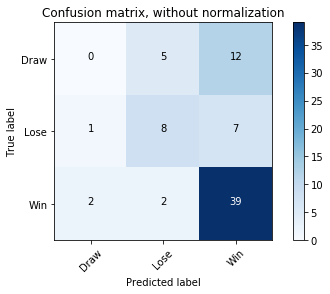

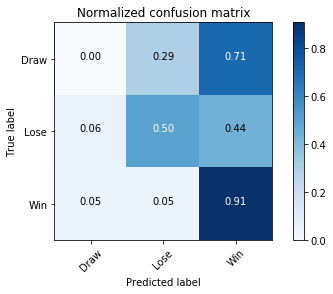

In [16]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()